In [18]:
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt


## Data preparation

In [19]:
# df_gdp = pd.read_csv("../gdp_analysis/results/gdp_weighted_pop_fifty.csv")
df_gdp = pd.read_csv("other_data/gdp_weighted_pop_decade.csv")
df_gdp = df_gdp.rename(columns={"region": "region_name"})

#df_cultura = pd.read_csv("../unseen_species_model/results/occupation/raw_results.csv", index_col = [0])
#df_cultura = pd.read_csv("../unseen_species_model/results_50/raw_results.csv", index_col = [0])

# Load Unseen-species data
# path = 'unseen_species_model/unseen_species_model.csv'
# path = 'unseen_species_model/unseen_species_model_no_occupation.csv'
path = 'unseen_species_model/unseen_species_model_bayesian.csv'

df_cultura = pd.read_csv(path, index_col = [0])
# df_cultura = df_cultura.rename(columns = {'f0_min':'min_f0', 'f0_max':'max_f0'})

df_cultura['N_est'] = df_cultura['f0'] + df_cultura['f1'] + df_cultura['f2']# plus the individual
df_cultura = df_cultura.groupby(['region_name', 'decade']).agg({'N_est': 'sum', 'individual_wikidata_id':'count'}).reset_index()
df_cultura = df_cultura.rename(columns={"individual_wikidata_id": "score"})
df_cultura['survival_ratio'] = df_cultura['score']/df_cultura['N_est']


df = pd.merge(df_gdp, df_cultura, on = ['region_name', 'decade'])
df = df.rename(columns = {'decade': 'year', 'gdp_pc_weighted':'gdp_per_capita'})


df['score_cap'] = df['score']/df['pop']
df['N_est_cap'] = df['N_est']/df['pop']


list(set(df.region_name))
df.region_name.value_counts()

keep = ['Indian world',
 'Nordic countries',
 'Persian world',
 'Portugal',
 'United Kingdom',
 'France',
 'Greek World',
 'Arabic world',
 'Chinese world',
 'Japan',
 'German world',
 'Low countries',
 'Italy',
 'Korea',
 'Spain']

# Apply normalization

df["century"] = df["year"].round(-2)
df["score_log"] = np.log(df["score"])
df["score_cap_log"] = np.log(df["score_cap"])

df["N_est_log"] = np.log(df["N_est"])
df["N_est_cap_log"] = np.log(df["N_est_cap"])
df["score_log_std"] = df["score_log"] / df["score_log"].mean()
df["score_cap_log_std"] = np.log(df["score_cap"]) / df["score_cap_log"].mean()

df["N_est_std"] = df["N_est"] / df["N_est"].mean()
df["N_est_log_std"] = df["N_est_log"] / df["N_est_log"].mean()

df["N_est_cap_log_std"] = np.log(df["N_est_cap"]) / df["N_est_cap_log"].mean()
df["log_gdp"] = np.log(df["gdp_per_capita"])

df["log_gdp_std"] = df["log_gdp"] / df["log_gdp"].mean()
df["gdp_std"] = df["gdp_per_capita"] / df["gdp_per_capita"].mean()
df["survival_ratio_std"] = df["survival_ratio"] / df["survival_ratio"].mean()

df['pop_log'] =  np.log(df["pop"])
df["pop_log_std"] = df["pop_log"] / df["pop_log"].mean()

## Corrected CPI

In [20]:
tables_dict = {}

/Users/charlesdedampierre/Desktop/cultura_project/.venv/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


          Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: log_gdp_std
No. Observations: 508     Method:             REML       
No. Groups:       15      Scale:              0.0006     
Min. group size:  2       Log-Likelihood:     1119.1637  
Max. group size:  64      Converged:          Yes        
Mean group size:  33.9                                   
---------------------------------------------------------
                Coef. Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------
Intercept       0.924    0.011 86.062 0.000  0.903  0.945
N_est_log_std   0.063    0.004 15.403 0.000  0.055  0.071
Group Var       0.001    0.024                           



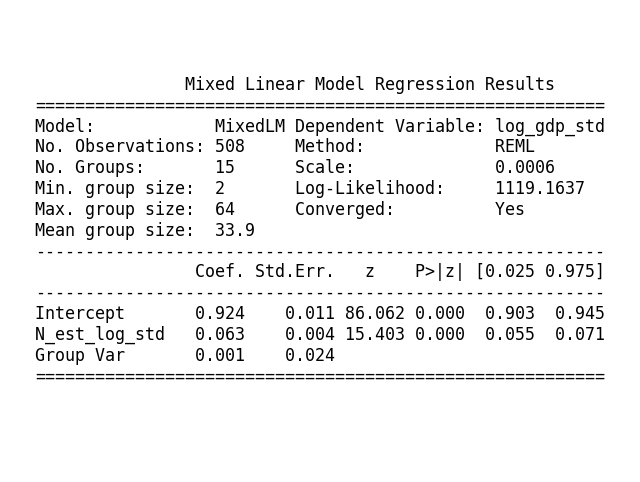

In [21]:
df_ols = df[['region_name', 'year', 'log_gdp_std', 'N_est_log_std', 'score_log_std']].copy()


# Mixed Effects Model
model = smf.mixedlm("log_gdp_std ~ N_est_log_std", df_ols, groups=df_ols["region_name"])
result = model.fit()


sm_table = result.summary().tables[1]
sm_table.index = ['Intercept', 'alpha', 'Group Var']
sm_table['model'] = 'Corrected CPI'
sm_table = sm_table.reset_index()
tables_dict['Corrected CPI'] = sm_table


# Output model summary to get R-square values if available (typically for OLS, not directly for MixedLM)
print(result.summary())


# Plotting the summary text
fig, ax = plt.subplots(figsize=(8, 6))
ax.text(0.5, 0.5, result.summary(), fontsize=12, va='center', ha='center', fontname='Monospace')
ax.axis('off')  # Turn off the axis

plt.savefig('model_summary.png', dpi=300, bbox_inches='tight', pad_inches=0.5)


In [22]:
result.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
          Mixed Linear Model Regression Results
=========================================================
Model:            MixedLM Dependent Variable: log_gdp_std
No. Observations: 508     Method:             REML       
No. Groups:       15      Scale:              0.0006     
Min. group size:  2       Log-Likelihood:     1119.1637  
Max. group size:  64      Converged:          Yes        
Mean group size:  33.9                                   
---------------------------------------------------------
                Coef. Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------
Intercept       0.924    0.011 86.062 0.000  0.903  0.945
N_est_log_std   0.063    0.004 15.403 0.000  0.055  0.071
Group Var       0.001    0.024                           
=========================================================

"""

                            OLS Regression Results                            
Dep. Variable:            log_gdp_std   R-squared:                       0.239
Model:                            OLS   Adj. R-squared:                  0.237
Method:                 Least Squares   F-statistic:                     158.6
Date:                Sun, 13 Oct 2024   Prob (F-statistic):           7.90e-32
Time:                        18:05:38   Log-Likelihood:                 883.24
No. Observations:                 508   AIC:                            -1762.
Df Residuals:                     506   BIC:                            -1754.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.9331      0.006    165.576

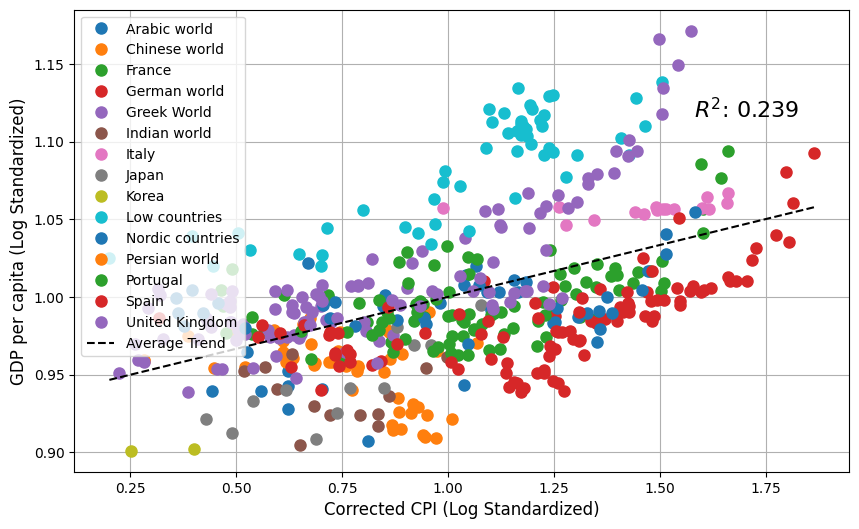

In [23]:


# Fitting an OLS model to obtain a single average trend line across all data
average_ols_model = smf.ols("log_gdp_std ~ N_est_log_std", data=df_ols).fit()
#average_ols_model = smf.mixedlm("log_gdp_std ~ N_est_log_std", df_ols, groups=df_ols["region_name"]).fit()
print(average_ols_model.summary())

# Prepare plot for relationship with a single average trend line
plt.figure(figsize=(10, 6))
for name, group in df_ols.groupby('region_name'):
    plt.plot(group['N_est_log_std'], group['log_gdp_std'], marker='o', linestyle='', ms=8, label=name)

# Calculate the average trend line across all data
x_vals = np.linspace(df_ols['N_est_log_std'].min(), df_ols['N_est_log_std'].max(), 100)
y_vals = average_ols_model.params['Intercept'] + average_ols_model.params['N_est_log_std'] * x_vals
plt.plot(x_vals, y_vals, 'k--', label='Average Trend')

plt.legend()
plt.xlabel('Corrected CPI (Log Standardized)', fontsize=12)
plt.ylabel('GDP per capita (Log Standardized)', fontsize=12)
plt.title('')
plt.grid(True)

# Show R-squared on the plot for the average trend line
r_squared = average_ols_model.rsquared
plt.figtext(0.85, 0.7, f'$R^2$: {r_squared:.3f}', ha='right', fontsize=16)

plt.show()

/var/folders/lx/9b13r6ln63jb54_3xlf9b_380000gn/T/ipykernel_87966/1590067226.py:19: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot(x_vals, y_vals, 'k--', color=color_map[name], label=None)
/var/folders/lx/9b13r6ln63jb54_3xlf9b_380000gn/T/ipykernel_87966/1590067226.py:19: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot(x_vals, y_vals, 'k--', color=color_map[name], label=None)
/var/folders/lx/9b13r6ln63jb54_3xlf9b_380000gn/T/ipykernel_87966/1590067226.py:19: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot(x_vals, y_vals, 'k--', color=color_map[name], label=None)
/var/folders/lx/9b13r6ln63jb54_3xlf9b_380000gn/T/ipykernel_87966/15900

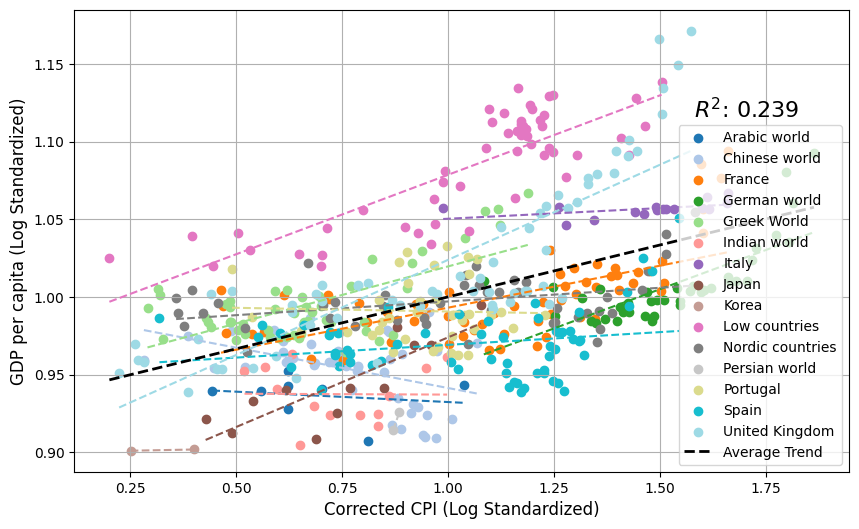

In [24]:

cmap = plt.get_cmap('tab20')
unique_regions = df_ols['region_name'].unique()
colors = cmap(np.linspace(0, 1, len(unique_regions)))
color_map = dict(zip(unique_regions, colors))

plt.figure(figsize=(10, 6))

# Plot individual data points and fit a regression line for each region
for name, group in df_ols.groupby('region_name'):
    # Fit OLS model for each region
    individual_ols_model = smf.ols("log_gdp_std ~ N_est_log_std", data=group).fit()
    
    # Plotting the scatter for each group
    plt.scatter(group['N_est_log_std'], group['log_gdp_std'], color=color_map[name], label=name)
    
    # Calculating the regression line
    x_vals = np.linspace(group['N_est_log_std'].min(), group['N_est_log_std'].max(), 100)
    y_vals = individual_ols_model.params['Intercept'] + individual_ols_model.params['N_est_log_std'] * x_vals
    plt.plot(x_vals, y_vals, 'k--', color=color_map[name], label=None)

# Fit a global OLS model to get the average trend line
average_ols_model = smf.ols("log_gdp_std ~ N_est_log_std", data=df_ols).fit()

# Calculate and plot the average trend line
x_vals_global = np.linspace(df_ols['N_est_log_std'].min(), df_ols['N_est_log_std'].max(), 100)
y_vals_global = average_ols_model.params['Intercept'] + average_ols_model.params['N_est_log_std'] * x_vals_global
plt.plot(x_vals_global, y_vals_global, 'k--', label='Average Trend', linewidth=2)

plt.legend()
plt.xlabel('Corrected CPI (Log Standardized)', fontsize=12)
plt.ylabel('GDP per capita (Log Standardized)', fontsize=12)
plt.title('')
plt.grid(True)

# Display R-squared for the average trend line
r_squared = average_ols_model.rsquared
plt.figtext(0.85, 0.7, f'$R^2$: {r_squared:.3f}', ha='right', fontsize=16)

plt.show()

## CPI

          Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: log_gdp_std
No. Observations: 508     Method:             REML       
No. Groups:       15      Scale:              0.0006     
Min. group size:  2       Log-Likelihood:     1133.6264  
Max. group size:  64      Converged:          Yes        
Mean group size:  33.9                                   
---------------------------------------------------------
                Coef. Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------
Intercept       0.944    0.010 90.286 0.000  0.924  0.965
score_log_std   0.042    0.003 16.810 0.000  0.037  0.047
Group Var       0.002    0.025                           



/Users/charlesdedampierre/Desktop/cultura_project/.venv/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


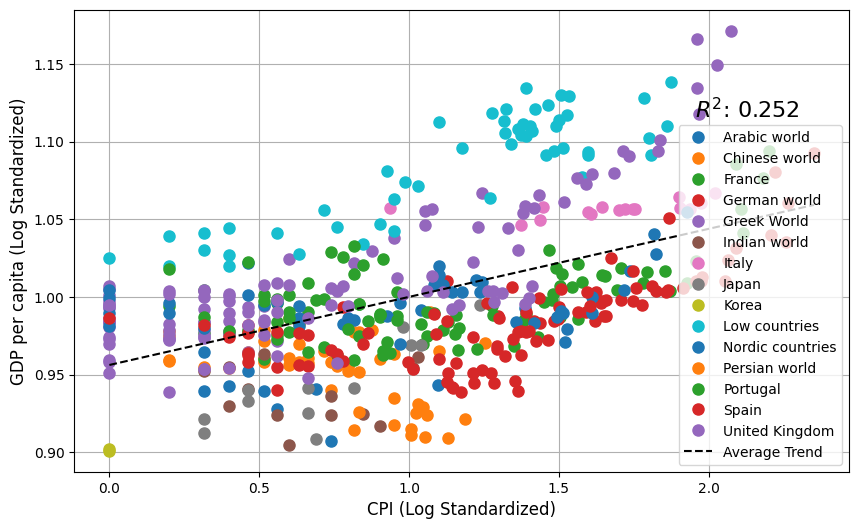

In [25]:
# Mixed Effects Model
model = smf.mixedlm("log_gdp_std ~ score_log_std", df_ols, groups=df_ols["region_name"])
result = model.fit()


sm_table = result.summary().tables[1]
sm_table.index = ['Intercept', 'alpha', 'Group Var']
sm_table['model'] = 'CPI'
sm_table = sm_table.reset_index()
tables_dict['CPI'] = sm_table

# Output model summary to get R-square values if available (typically for OLS, not directly for MixedLM)
print(result.summary())

# Fitting an OLS model to obtain a single average trend line across all data
average_ols_model = smf.ols("log_gdp_std ~ score_log_std", data=df_ols).fit()

# Prepare plot for relationship with a single average trend line
plt.figure(figsize=(10, 6))
for name, group in df_ols.groupby('region_name'):
    plt.plot(group['score_log_std'], group['log_gdp_std'], marker='o', linestyle='', ms=8, label=name)

# Calculate the average trend line across all data
x_vals = np.linspace(df_ols['score_log_std'].min(), df_ols['score_log_std'].max(), 100)
y_vals = average_ols_model.params['Intercept'] + average_ols_model.params['score_log_std'] * x_vals
plt.plot(x_vals, y_vals, 'k--', label='Average Trend')

plt.legend()
plt.xlabel('CPI (Log Standardized)', fontsize=12)
plt.ylabel('GDP per capita (Log Standardized)', fontsize=12)
plt.title('')
plt.grid(True)

# Show R-squared on the plot for the average trend line
r_squared = average_ols_model.rsquared
plt.figtext(0.85, 0.7, f'$R^2$: {r_squared:.3f}', ha='right', fontsize=16)

plt.show()

/var/folders/lx/9b13r6ln63jb54_3xlf9b_380000gn/T/ipykernel_87966/2229280083.py:19: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot(x_vals, y_vals, 'k--', color=color_map[name], label=None)
/var/folders/lx/9b13r6ln63jb54_3xlf9b_380000gn/T/ipykernel_87966/2229280083.py:19: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot(x_vals, y_vals, 'k--', color=color_map[name], label=None)
/var/folders/lx/9b13r6ln63jb54_3xlf9b_380000gn/T/ipykernel_87966/2229280083.py:19: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot(x_vals, y_vals, 'k--', color=color_map[name], label=None)
/var/folders/lx/9b13r6ln63jb54_3xlf9b_380000gn/T/ipykernel_87966/22292

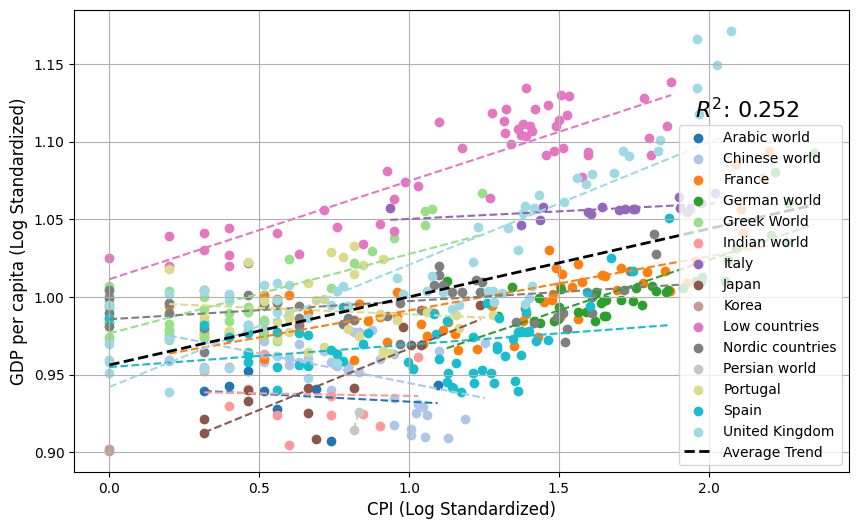

In [26]:

cmap = plt.get_cmap('tab20')
unique_regions = df_ols['region_name'].unique()
colors = cmap(np.linspace(0, 1, len(unique_regions)))
color_map = dict(zip(unique_regions, colors))

plt.figure(figsize=(10, 6))

# Plot individual data points and fit a regression line for each region
for name, group in df_ols.groupby('region_name'):
    # Fit OLS model for each region
    individual_ols_model = smf.ols("log_gdp_std ~ score_log_std", data=group).fit()
    
    # Plotting the scatter for each group
    plt.scatter(group['score_log_std'], group['log_gdp_std'], color=color_map[name], label=name)
    
    # Calculating the regression line
    x_vals = np.linspace(group['score_log_std'].min(), group['score_log_std'].max(), 100)
    y_vals = individual_ols_model.params['Intercept'] + individual_ols_model.params['score_log_std'] * x_vals
    plt.plot(x_vals, y_vals, 'k--', color=color_map[name], label=None)

# Fit a global OLS model to get the average trend line
average_ols_model = smf.ols("log_gdp_std ~ score_log_std", data=df_ols).fit()

# Calculate and plot the average trend line
x_vals_global = np.linspace(df_ols['score_log_std'].min(), df_ols['score_log_std'].max(), 100)
y_vals_global = average_ols_model.params['Intercept'] + average_ols_model.params['score_log_std'] * x_vals_global
plt.plot(x_vals_global, y_vals_global, 'k--', label='Average Trend', linewidth=2)

plt.legend()
plt.xlabel('CPI (Log Standardized)', fontsize=12)
plt.ylabel('GDP per capita (Log Standardized)', fontsize=12)
plt.title('')
plt.grid(True)

# Display R-squared for the average trend line
r_squared = average_ols_model.rsquared
plt.figtext(0.85, 0.7, f'$R^2$: {r_squared:.3f}', ha='right', fontsize=16)

plt.show()

## Corrected CPI 1800-1880

          Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: log_gdp_std
No. Observations: 107     Method:             REML       
No. Groups:       15      Scale:              0.0003     
Min. group size:  2       Log-Likelihood:     252.8262   
Max. group size:  9       Converged:          Yes        
Mean group size:  7.1                                    
---------------------------------------------------------
                Coef. Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------
Intercept       0.807    0.022 36.064 0.000  0.763  0.851
N_est_log_std   0.164    0.016 10.028 0.000  0.132  0.196
Group Var       0.002    0.049                           

                            OLS Regression Results                            
Dep. Variable:            log_gdp_std   R-squared:                       0.514
Model:                            OLS   Adj. R-squared:                  0.509
Method:           

/Users/charlesdedampierre/Desktop/cultura_project/.venv/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


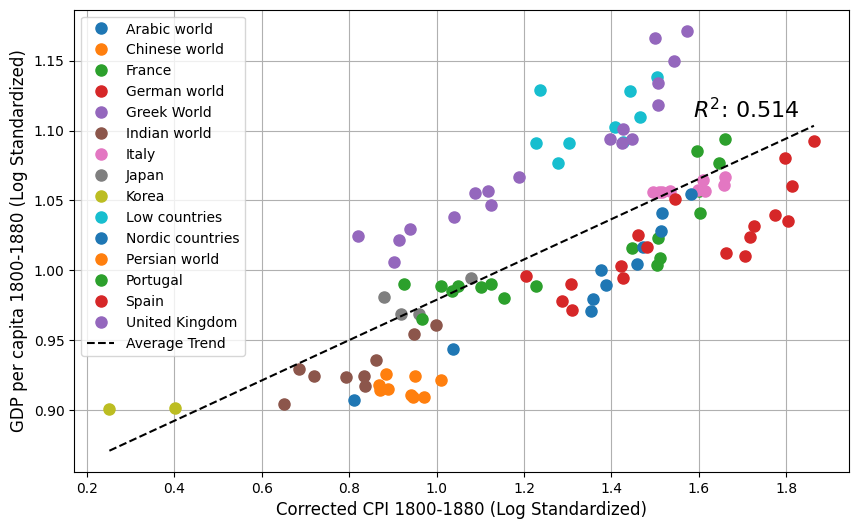

In [27]:
df_ols = df[['region_name', 'year', 'log_gdp_std', 'N_est_log_std', 'score_log_std']].copy()
df_ols = df_ols[df_ols['year']>=1800]
df_ols.region_name.value_counts()

# Mixed Effects Model
model = smf.mixedlm("log_gdp_std ~ N_est_log_std", df_ols, groups=df_ols["region_name"])
result = model.fit()

# Output model summary to get R-square values if available (typically for OLS, not directly for MixedLM)
print(result.summary())

sm_table = result.summary().tables[1]
sm_table.index = ['Intercept', 'alpha', 'Group Var']
sm_table['model'] = 'Corrected CPI 1800-1880'
sm_table = sm_table.reset_index()
tables_dict['Corrected CPI 1800-1880'] = sm_table


# Fitting an OLS model to obtain a single average trend line across all data
average_ols_model = smf.ols("log_gdp_std ~ N_est_log_std", data=df_ols).fit()
#average_ols_model = smf.mixedlm("log_gdp_std ~ N_est_log_std", df_ols, groups=df_ols["region_name"]).fit()
print(average_ols_model.summary())

# Prepare plot for relationship with a single average trend line
plt.figure(figsize=(10, 6))
for name, group in df_ols.groupby('region_name'):
    plt.plot(group['N_est_log_std'], group['log_gdp_std'], marker='o', linestyle='', ms=8, label=name)

# Calculate the average trend line across all data
x_vals = np.linspace(df_ols['N_est_log_std'].min(), df_ols['N_est_log_std'].max(), 100)
y_vals = average_ols_model.params['Intercept'] + average_ols_model.params['N_est_log_std'] * x_vals
plt.plot(x_vals, y_vals, 'k--', label='Average Trend')

plt.legend()
plt.xlabel('Corrected CPI 1800-1880 (Log Standardized)', fontsize=12)
plt.ylabel('GDP per capita 1800-1880 (Log Standardized)', fontsize=12)
plt.title('')
plt.grid(True)

# Show R-squared on the plot for the average trend line
r_squared = average_ols_model.rsquared


plt.figtext(0.85, 0.7, f'$R^2$: {r_squared:.3f}', ha='right', fontsize=16)

plt.show()



/var/folders/lx/9b13r6ln63jb54_3xlf9b_380000gn/T/ipykernel_87966/3500337800.py:19: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot(x_vals, y_vals, 'k--', color=color_map[name], label=None)
/var/folders/lx/9b13r6ln63jb54_3xlf9b_380000gn/T/ipykernel_87966/3500337800.py:19: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot(x_vals, y_vals, 'k--', color=color_map[name], label=None)
/var/folders/lx/9b13r6ln63jb54_3xlf9b_380000gn/T/ipykernel_87966/3500337800.py:19: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot(x_vals, y_vals, 'k--', color=color_map[name], label=None)
/var/folders/lx/9b13r6ln63jb54_3xlf9b_380000gn/T/ipykernel_87966/35003

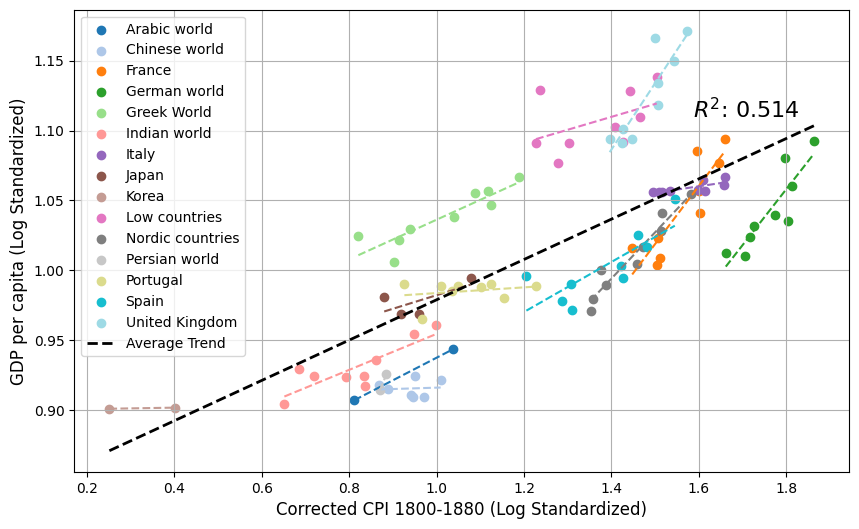

In [28]:

cmap = plt.get_cmap('tab20')
unique_regions = df_ols['region_name'].unique()
colors = cmap(np.linspace(0, 1, len(unique_regions)))
color_map = dict(zip(unique_regions, colors))

plt.figure(figsize=(10, 6))

# Plot individual data points and fit a regression line for each region
for name, group in df_ols.groupby('region_name'):
    # Fit OLS model for each region
    individual_ols_model = smf.ols("log_gdp_std ~ N_est_log_std", data=group).fit()
    
    # Plotting the scatter for each group
    plt.scatter(group['N_est_log_std'], group['log_gdp_std'], color=color_map[name], label=name)
    
    # Calculating the regression line
    x_vals = np.linspace(group['N_est_log_std'].min(), group['N_est_log_std'].max(), 100)
    y_vals = individual_ols_model.params['Intercept'] + individual_ols_model.params['N_est_log_std'] * x_vals
    plt.plot(x_vals, y_vals, 'k--', color=color_map[name], label=None)

# Fit a global OLS model to get the average trend line
average_ols_model = smf.ols("log_gdp_std ~ N_est_log_std", data=df_ols).fit()

# Calculate and plot the average trend line
x_vals_global = np.linspace(df_ols['N_est_log_std'].min(), df_ols['N_est_log_std'].max(), 100)
y_vals_global = average_ols_model.params['Intercept'] + average_ols_model.params['N_est_log_std'] * x_vals_global
plt.plot(x_vals_global, y_vals_global, 'k--', label='Average Trend', linewidth=2)

plt.legend()
plt.xlabel('Corrected CPI 1800-1880 (Log Standardized)', fontsize=12)
plt.ylabel('GDP per capita (Log Standardized)', fontsize=12)
plt.title('')
plt.grid(True)

# Display R-squared for the average trend line
r_squared = average_ols_model.rsquared
plt.figtext(0.85, 0.7, f'$R^2$: {r_squared:.3f}', ha='right', fontsize=16)

plt.show()

## CPI 1800-1880

          Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: log_gdp_std
No. Observations: 107     Method:             REML       
No. Groups:       15      Scale:              0.0003     
Min. group size:  2       Log-Likelihood:     250.5761   
Max. group size:  9       Converged:          Yes        
Mean group size:  7.1                                    
---------------------------------------------------------
                Coef. Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------
Intercept       0.877    0.017 52.166 0.000  0.844  0.910
score_log_std   0.094    0.010  9.810 0.000  0.075  0.113
Group Var       0.002    0.045                           

                            OLS Regression Results                            
Dep. Variable:            log_gdp_std   R-squared:                       0.529
Model:                            OLS   Adj. R-squared:                  0.524
Method:           

/Users/charlesdedampierre/Desktop/cultura_project/.venv/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


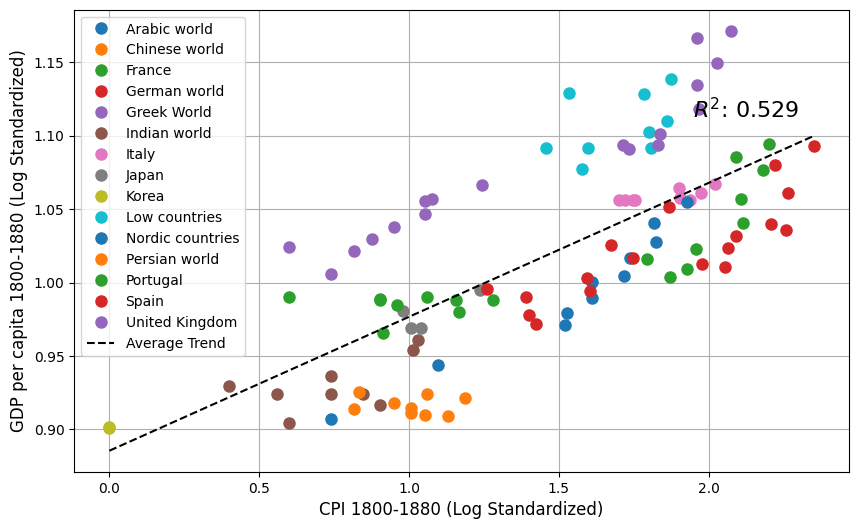

In [29]:
df_ols = df[['region_name', 'year', 'log_gdp_std', 'N_est_log_std', 'score_log_std']].copy()
df_ols = df_ols[df_ols['year']>=1800]
df_ols.region_name.value_counts()

# Mixed Effects Model
model = smf.mixedlm("log_gdp_std ~ score_log_std", df_ols, groups=df_ols["region_name"])
result = model.fit()

# Output model summary to get R-square values if available (typically for OLS, not directly for MixedLM)
print(result.summary())

sm_table = result.summary().tables[1]
sm_table.index = ['Intercept', 'alpha', 'Group Var']
sm_table['model'] = 'CPI 1800-1880'
sm_table = sm_table.reset_index()
tables_dict['CPI 1800-1880'] = sm_table


# Fitting an OLS model to obtain a single average trend line across all data
average_ols_model = smf.ols("log_gdp_std ~ score_log_std", data=df_ols).fit()
#average_ols_model = smf.mixedlm("log_gdp_std ~ N_est_log_std", df_ols, groups=df_ols["region_name"]).fit()
print(average_ols_model.summary())

# Prepare plot for relationship with a single average trend line
plt.figure(figsize=(10, 6))
for name, group in df_ols.groupby('region_name'):
    plt.plot(group['score_log_std'], group['log_gdp_std'], marker='o', linestyle='', ms=8, label=name)

# Calculate the average trend line across all data
x_vals = np.linspace(df_ols['score_log_std'].min(), df_ols['score_log_std'].max(), 100)
y_vals = average_ols_model.params['Intercept'] + average_ols_model.params['score_log_std'] * x_vals
plt.plot(x_vals, y_vals, 'k--', label='Average Trend')

plt.legend()
plt.xlabel('CPI 1800-1880 (Log Standardized)', fontsize=12)
plt.ylabel('GDP per capita 1800-1880 (Log Standardized)', fontsize=12)
plt.title('')
plt.grid(True)

# Show R-squared on the plot for the average trend line
r_squared = average_ols_model.rsquared


plt.figtext(0.85, 0.7, f'$R^2$: {r_squared:.3f}', ha='right', fontsize=16)

plt.show()

/var/folders/lx/9b13r6ln63jb54_3xlf9b_380000gn/T/ipykernel_87966/406418901.py:19: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot(x_vals, y_vals, 'k--', color=color_map[name], label=None)
/var/folders/lx/9b13r6ln63jb54_3xlf9b_380000gn/T/ipykernel_87966/406418901.py:19: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot(x_vals, y_vals, 'k--', color=color_map[name], label=None)
/var/folders/lx/9b13r6ln63jb54_3xlf9b_380000gn/T/ipykernel_87966/406418901.py:19: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot(x_vals, y_vals, 'k--', color=color_map[name], label=None)
/var/folders/lx/9b13r6ln63jb54_3xlf9b_380000gn/T/ipykernel_87966/40641890

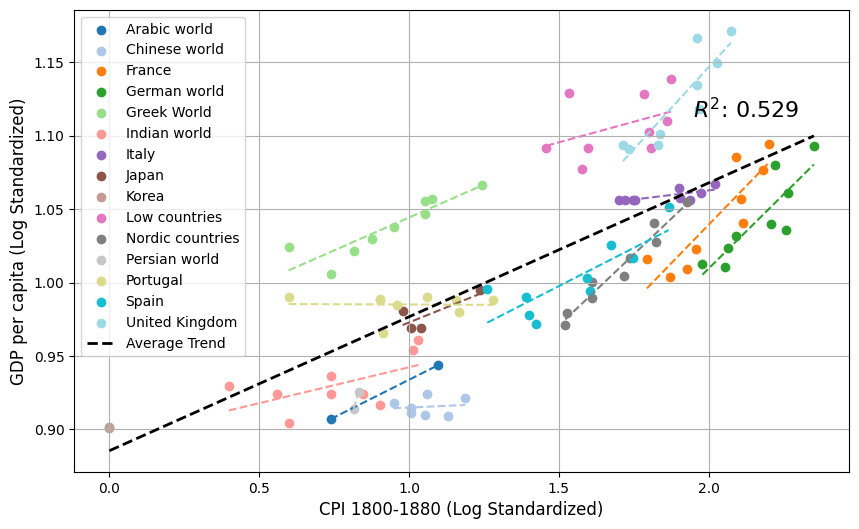

In [30]:

cmap = plt.get_cmap('tab20')
unique_regions = df_ols['region_name'].unique()
colors = cmap(np.linspace(0, 1, len(unique_regions)))
color_map = dict(zip(unique_regions, colors))

plt.figure(figsize=(10, 6))

# Plot individual data points and fit a regression line for each region
for name, group in df_ols.groupby('region_name'):
    # Fit OLS model for each region
    individual_ols_model = smf.ols("log_gdp_std ~ score_log_std", data=group).fit()
    
    # Plotting the scatter for each group
    plt.scatter(group['score_log_std'], group['log_gdp_std'], color=color_map[name], label=name)
    
    # Calculating the regression line
    x_vals = np.linspace(group['score_log_std'].min(), group['score_log_std'].max(), 100)
    y_vals = individual_ols_model.params['Intercept'] + individual_ols_model.params['score_log_std'] * x_vals
    plt.plot(x_vals, y_vals, 'k--', color=color_map[name], label=None)

# Fit a global OLS model to get the average trend line
average_ols_model = smf.ols("log_gdp_std ~ score_log_std", data=df_ols).fit()

# Calculate and plot the average trend line
x_vals_global = np.linspace(df_ols['score_log_std'].min(), df_ols['score_log_std'].max(), 100)
y_vals_global = average_ols_model.params['Intercept'] + average_ols_model.params['score_log_std'] * x_vals_global
plt.plot(x_vals_global, y_vals_global, 'k--', label='Average Trend', linewidth=2)

plt.legend()
plt.xlabel('CPI 1800-1880 (Log Standardized)', fontsize=12)
plt.ylabel('GDP per capita (Log Standardized)', fontsize=12)
plt.title('')
plt.grid(True)

# Display R-squared for the average trend line
r_squared = average_ols_model.rsquared
plt.figtext(0.85, 0.7, f'$R^2$: {r_squared:.3f}', ha='right', fontsize=16)

plt.show()

#### Stats Table

In [31]:
final_table = pd.concat(tables_dict.values(), ignore_index=True).reset_index(drop=True)
final_table = final_table[final_table['index']=='alpha']
final_table = final_table.drop(['index', 'z'], axis=1)
final_table = final_table.sort_values('Coef.', ascending=True)
final_table = final_table.rename(columns={'[0.025':'0.025', '0.975]':'0.975'})
list(final_table.columns)

final_table['Coef.'] = final_table['Coef.'].astype(float)
final_table['0.025'] = final_table['0.025'].astype(float)
final_table['0.975'] = final_table['0.975'].astype(float)
final_table['P>|z|'] = final_table['P>|z|'].astype(float)
final_table = final_table.reset_index(drop=True)
final_table['model'] = final_table['model'] + ' vs GDP per Capita'
final_table

,Coef.,Std.Err.,P>|z|,0.025,0.975,model
0,0.042,0.003,0.0,0.037,0.047,CPI vs GDP per Capita
1,0.063,0.004,0.0,0.055,0.071,Corrected CPI vs GDP per Capita
2,0.094,0.010,0.0,0.075,0.113,CPI 1800-1880 vs GDP per Capita
3,0.164,0.016,0.0,0.132,0.196,Corrected CPI 1800-1880 vs GDP per Capita


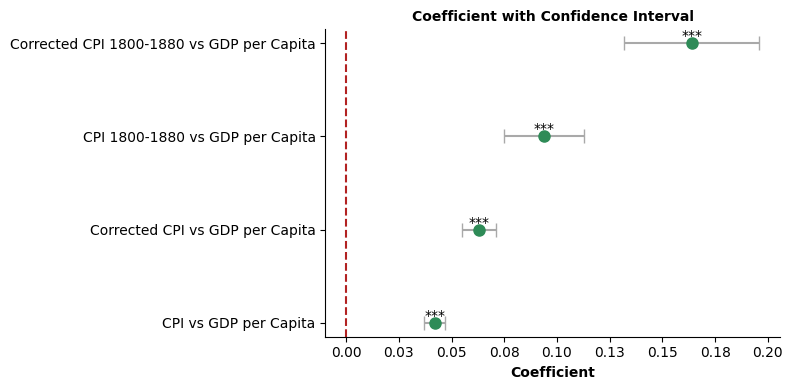

In [32]:
fig, ax = plt.subplots(figsize=(8, 4))  # Increased figure size for more models

# Plot the data points and error bars
ax.errorbar(final_table['Coef.'], final_table['model'], 
            xerr=[final_table['Coef.'] - final_table['0.025'], 
                  final_table['0.975'] - final_table['Coef.']],
            fmt='o', capsize=5, ecolor='darkgray', markersize=8, 
            color='seagreen', linewidth=1.5, zorder=2)

# Add a vertical line at x=0
ax.axvline(x=0, color='firebrick', linestyle='--', linewidth=1.5, zorder=1)

# Add *** on top of the green dots
for i, model in enumerate(final_table['model']):
    ax.text(final_table['Coef.'][i], model, '***', ha='center', va='bottom', color='black', fontsize=10)

# Customize the plot
ax.set_xlabel('Coefficient', fontweight='bold')
ax.set_ylabel('', fontweight='bold')
ax.set_title('Coefficient with Confidence Interval', fontsize=10, fontweight='bold')

# Adjust the x-axis to show more precision
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f"{x:.2f}"))

# Remove top and right spines for a cleaner look
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

### Population data

###  Checking for multicolinearity

In [43]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# Assuming 'df' is your DataFrame and it contains all relevant predictors
X = add_constant(df[['N_est_log_std', 'pop_log_std']])  # adding a constant is essential for VIF calculation

VIF = pd.DataFrame()
VIF["Variable"] = X.columns
VIF["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(VIF)


        Variable        VIF
0          const  44.138984
1  N_est_log_std   1.007166
2    pop_log_std   1.007166


In [44]:
# Assuming 'df' is your DataFrame
correlation_matrix = df[['N_est_log_std', 'pop_log_std']].corr()
correlation_matrix

,N_est_log_std,pop_log_std
N_est_log_std,1.000000,0.084351
pop_log_std,0.084351,1.000000


In [45]:
list(df.columns)

['region_name',
 'year',
 'gdp_per_capita',
 'pop',
 'N_est',
 'score',
 'survival_ratio',
 'score_cap',
 'N_est_cap',
 'century',
 'score_log',
 'score_cap_log',
 'N_est_log',
 'N_est_cap_log',
 'score_log_std',
 'score_cap_log_std',
 'N_est_std',
 'N_est_log_std',
 'N_est_cap_log_std',
 'log_gdp',
 'log_gdp_std',
 'gdp_std',
 'survival_ratio_std',
 'pop_log',
 'pop_log_std']

/Users/charlesdedampierre/Desktop/cultura_project/.venv/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


          Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: log_gdp_std
No. Observations: 508     Method:             REML       
No. Groups:       15      Scale:              0.0006     
Min. group size:  2       Log-Likelihood:     1135.7082  
Max. group size:  64      Converged:          Yes        
Mean group size:  33.9                                   
---------------------------------------------------------
                Coef. Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------
Intercept       0.744    0.033 22.555 0.000  0.679  0.809
N_est_log_std   0.033    0.006  5.366 0.000  0.021  0.045
pop_log_std     0.205    0.032  6.314 0.000  0.141  0.268
Group Var       0.004    0.069                           



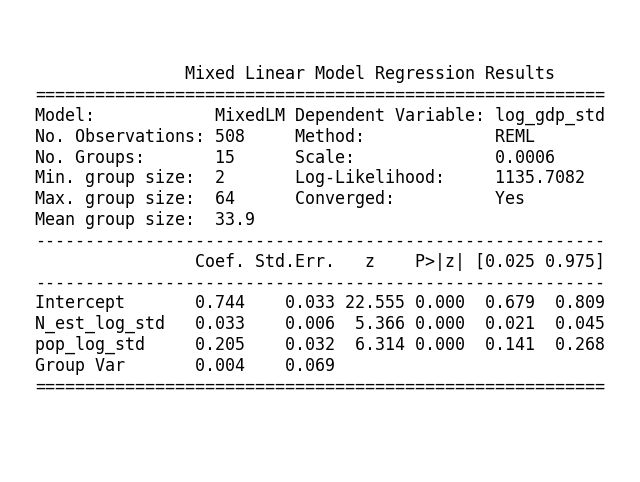

In [49]:
df_ols_pop = df[['region_name', 'year', 'log_gdp_std', 'N_est_log_std', 'score_log_std', 'pop_log_std']].copy()

# Mixed Effects Model
model = smf.mixedlm("log_gdp_std ~ N_est_log_std + pop_log_std", df_ols_pop, groups=df_ols_pop["region_name"])
result = model.fit()

print(result.summary())

sm_table.index = ['Intercept', 'CCPI', "Population",'Group Var']
sm_table['model'] = 'Corrected CPI'
sm_table = sm_table.reset_index()

# Plotting the summary text
fig, ax = plt.subplots(figsize=(8, 6))
ax.text(0.5, 0.5, result.summary(), fontsize=12, va='center', ha='center', fontname='Monospace')
ax.axis('off')  # Turn off the axis

plt.savefig('model_summary_pop_ccpi.png', dpi=300, bbox_inches='tight', pad_inches=0.5)

,Coef.,Std.Err.,z,P>|z|,[0.025,0.975]
Intercept,0.744,0.033,22.555,0.000,0.679,0.809
N_est_log_std,0.033,0.006,5.366,0.000,0.021,0.045
pop_log_std,0.205,0.032,6.314,0.000,0.141,0.268
Group Var,0.004,0.069,,,,


/Users/charlesdedampierre/Desktop/cultura_project/.venv/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


          Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: log_gdp_std
No. Observations: 508     Method:             REML       
No. Groups:       15      Scale:              0.0005     
Min. group size:  2       Log-Likelihood:     1143.1033  
Max. group size:  64      Converged:          Yes        
Mean group size:  33.9                                   
---------------------------------------------------------
                Coef. Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------
Intercept       0.792    0.034 23.155 0.000  0.725  0.859
score_log_std   0.027    0.004  6.727 0.000  0.019  0.034
pop_log_std     0.164    0.033  4.953 0.000  0.099  0.228
Group Var       0.003    0.059                           



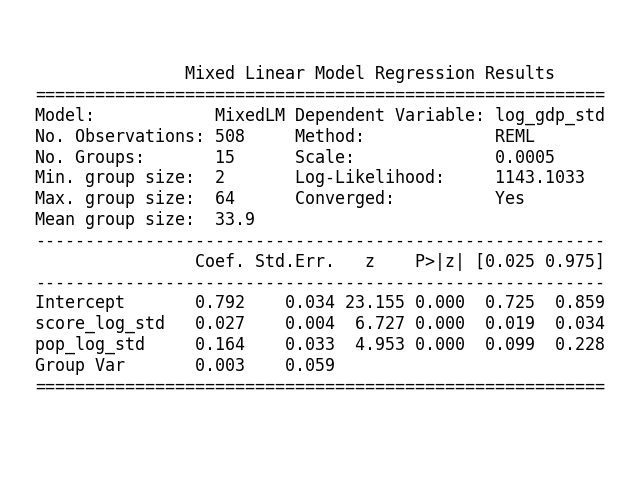

In [51]:
# Mixed Effects Model
model = smf.mixedlm("log_gdp_std ~ score_log_std + pop_log_std", df_ols_pop, groups=df_ols_pop["region_name"])
result = model.fit()

print(result.summary())

sm_table = result.summary().tables[1]
sm_table.index = ['Intercept', 'CPI', "Population",'Group Var']
sm_table['model'] = 'Corrected CPI'
sm_table = sm_table.reset_index()

# Plotting the summary text
fig, ax = plt.subplots(figsize=(8, 6))
ax.text(0.5, 0.5, result.summary(), fontsize=12, va='center', ha='center', fontname='Monospace')
ax.axis('off')  # Turn off the axis

plt.savefig('model_summary_pop_cpi.png', dpi=300, bbox_inches='tight', pad_inches=0.5)